In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
cleaned_data = pd.read_csv("dataset/cleaned_data3.csv")

In [3]:
cleaned_data.head(5)

,reviewerID,reviewText,clean_reviewText,clean_summary,rating_class
0,A3LDPF5FMB782Z,The Nook tablet is a great color e-reader with...,tablet great color e-reader bonus able read em...,great color e-reader extra feature,good
1,A2AEZQ3DGBBLPR,I bought this repair kit so I could watch a re...,repair kit could watch movie quite scratch ski...,create new scratch didn fix old ones,bad
2,ATY86XH2DJ4ZH,"I am not an audiophile, but I do care about th...",not audiophile care sound hear headset last we...,not really noise cancel headset,bad
3,A2ATP6ZTCPX1QX,I'm not one to complain much but I hate old pr...,not one complain much hate old products mix ne...,take old products .,bad
4,A3QPWNKTUC8N2B,I bought this ereader and the Amazon Kindle er...,ereader amazon kindle ereader time could compa...,favorite ereader,good


In [4]:
cleaned_data["rating_class"] = cleaned_data["rating_class"].apply(lambda x: 1 if x=="good" else 0)

In [5]:
cleaned_data.head(5)

,reviewerID,reviewText,clean_reviewText,clean_summary,rating_class
0,A3LDPF5FMB782Z,The Nook tablet is a great color e-reader with...,tablet great color e-reader bonus able read em...,great color e-reader extra feature,1
1,A2AEZQ3DGBBLPR,I bought this repair kit so I could watch a re...,repair kit could watch movie quite scratch ski...,create new scratch didn fix old ones,0
2,ATY86XH2DJ4ZH,"I am not an audiophile, but I do care about th...",not audiophile care sound hear headset last we...,not really noise cancel headset,0
3,A2ATP6ZTCPX1QX,I'm not one to complain much but I hate old pr...,not one complain much hate old products mix ne...,take old products .,0
4,A3QPWNKTUC8N2B,I bought this ereader and the Amazon Kindle er...,ereader amazon kindle ereader time could compa...,favorite ereader,1


In [6]:
Y = cleaned_data["rating_class"]
X = cleaned_data["clean_reviewText"]

In [7]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = tfidf_vect.fit_transform(X.values.astype("U"))
X_tfidf  = X_tfidf.toarray()

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selectK = SelectKBest(f_classif, k=1000)
selectK.fit(X_tfidf, Y)
X_sel = selectK.transform(X_tfidf)

In [9]:
tfidf_vect_train, tfidf_vect_test, Y_train, Y_test = train_test_split(X_sel, Y, test_size=0.2, random_state=42,shuffle=True, stratify = Y)

In [10]:
model = xgb.XGBClassifier(objective = 'binary:logistic',feature_selector= 'thrifty',top_k = '600',n_estimators=100, learning_rate =0.20, max_depth = 30,min_child_weight= 5,gamma = 0.5,colsample_bytree = 0.4)
t0 = time.time()
eval_s = [(tfidf_vect_train, Y_train), (tfidf_vect_test, Y_test)]
model.fit(tfidf_vect_train, Y_train, eval_metric=["aucpr","error"], verbose=True, eval_set = eval_s, early_stopping_rounds=20)
t1 = time.time()
xg_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
xg_time_linear_train = t1-t0
xg_time_linear_predict = t2-t1
xg_f1Score = f1_score(Y_test, xg_Ypred, average = "weighted")

[0]	validation_0-aucpr:0.846432	validation_0-error:0.22375	validation_1-aucpr:0.775736	validation_1-error:0.275
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-aucpr:0.878217	validation_0-error:0.18875	validation_1-aucpr:0.801166	validation_1-error:0.27
[2]	validation_0-aucpr:0.909877	validation_0-error:0.16375	validation_1-aucpr:0.804989	validation_1-error:0.245
[3]	validation_0-aucpr:0.913173	validation_0-error:0.1575	validation_1-aucpr:0.79604	validation_1-error:0.255
[4]	validation_0-aucpr:0.917171	validation_0-error:0.16125	validation_1-aucpr:0.843884	validation_1-error:0.23
[5]	validation_0-aucpr:0.926968	validation_0-error:0.14625	validation_1-aucpr:0.841202	validation_1-error:0.23
[6]	validation_0-aucpr:0.935286	validation_0-error:0.13375	validation_1-aucpr:0.844703	validation_1-error:0.225
[7]	validation_0-aucpr:0.938406	validation_0-error:0.1275	va

In [11]:
print("Training time: %fs; Prediction time: %fs" % (xg_time_linear_train, xg_time_linear_predict))

Training time: 2.472948s; Prediction time: 1.031030s


<AxesSubplot:>

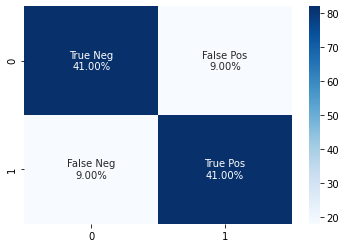

In [13]:
import seaborn as sns
import numpy as np 

cf_matrix = metrics.confusion_matrix(Y_test, xg_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [14]:
xg_f1Score

0.82

In [15]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, max_depth = 8)
t0 = time.time()
model.fit(tfidf_vect_train, Y_train)
t1 = time.time()
cat_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
cat_time_linear_train = t1-t0
cat_time_linear_predict = t2-t1
cat_f1Score = f1_score(Y_test, cat_Ypred, average = "weighted")

0:	learn: 0.6625526	total: 242ms	remaining: 1m 12s
1:	learn: 0.6405351	total: 300ms	remaining: 44.7s
2:	learn: 0.6225021	total: 360ms	remaining: 35.7s
3:	learn: 0.5953133	total: 419ms	remaining: 31s
4:	learn: 0.5803032	total: 507ms	remaining: 29.9s
5:	learn: 0.5614870	total: 612ms	remaining: 30s
6:	learn: 0.5477036	total: 708ms	remaining: 29.6s
7:	learn: 0.5341629	total: 787ms	remaining: 28.7s
8:	learn: 0.5241136	total: 853ms	remaining: 27.6s
9:	learn: 0.5106723	total: 908ms	remaining: 26.3s
10:	learn: 0.5000625	total: 963ms	remaining: 25.3s
11:	learn: 0.4906050	total: 1.02s	remaining: 24.6s
12:	learn: 0.4795351	total: 1.08s	remaining: 24s
13:	learn: 0.4707390	total: 1.14s	remaining: 23.4s
14:	learn: 0.4636198	total: 1.21s	remaining: 22.9s
15:	learn: 0.4560681	total: 1.27s	remaining: 22.6s
16:	learn: 0.4491228	total: 1.33s	remaining: 22.1s
17:	learn: 0.4440395	total: 1.39s	remaining: 21.8s
18:	learn: 0.4378838	total: 1.45s	remaining: 21.5s
19:	learn: 0.4325212	total: 1.51s	remaining: 2

In [16]:
print("Training time: %fs; Prediction time: %fs" % (cat_time_linear_train, cat_time_linear_predict))

Training time: 22.708619s; Prediction time: 0.059992s


<AxesSubplot:>

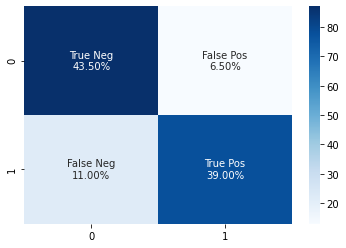

In [17]:
cf_matrix = metrics.confusion_matrix(Y_test, cat_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [18]:
cat_f1Score

0.8246449059345176

In [19]:
model = svm.SVC(C = 10)
t0 = time.time()
model.fit(tfidf_vect_train, Y_train)
t1 = time.time()
svc_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
svc_time_linear_train = t1-t0
svc_time_linear_predict = t2-t1
svc_f1Score = f1_score(Y_test, svc_Ypred, average = "weighted")

In [20]:
print("Training time: %fs; Prediction time: %fs" % (svc_time_linear_train, svc_time_linear_predict))

Training time: 0.905332s; Prediction time: 0.170733s


In [21]:
svc_f1Score

0.8849971249281232

<AxesSubplot:>

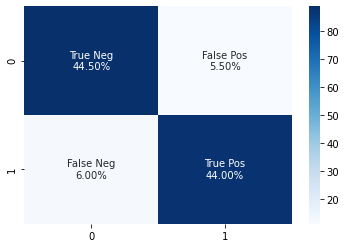

In [22]:
cf_matrix = metrics.confusion_matrix(Y_test, svc_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [23]:
f1_scores = [svc_f1Score, cat_f1Score, xg_f1Score]
train_time = [svc_time_linear_train, cat_time_linear_train, xg_time_linear_train]
predict_time = [svc_time_linear_predict, cat_time_linear_predict, xg_time_linear_predict]
algo_name = ["SVC", "CatBoost", "XGBoost"]

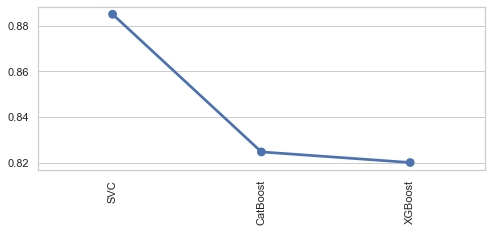

In [24]:
f1_scores = [svc_f1Score, cat_f1Score, xg_f1Score]
train_time = [svc_time_linear_train, cat_time_linear_train, xg_time_linear_train]
predict_time = [svc_time_linear_predict, cat_time_linear_predict, xg_time_linear_predict]
algo_name = ["SVC", "CatBoost", "XGBoost"]

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
ax = sns.pointplot(x = algo_name, y = f1_scores)
ax.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()

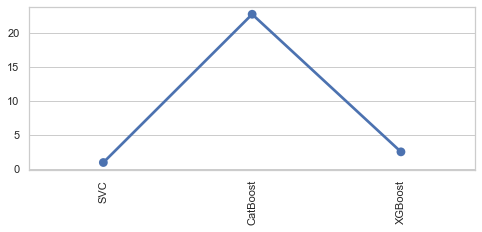

In [25]:
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
bx = sns.pointplot(x = algo_name, y = train_time)
bx.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()

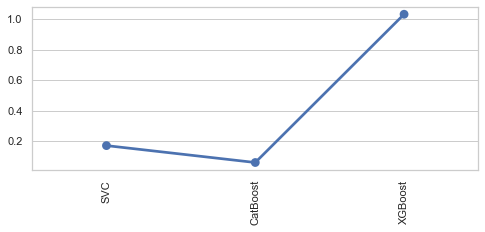

In [26]:
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
cx = sns.pointplot(x = algo_name, y = predict_time)
cx.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()